# Tema 7: Perceptron multistrat antrenat cu Pytorch

## Descrierea temei
Implementati un model de perceptron multistrat pentru clasificarea celor 10 clase din setul [Fashion MNIST](https://www.kaggle.com/datasets/zalando-research/fashionmnist).

Puteti reutiliza si adapta cod din exemplul Pytorch pentru regresia logistica binara, din tema 5 (săptămâna 19 noiembrie - 25 noiembrie, de pe platforma elearning).

Modificarile pe care trebuie sa le aveti in vedere sunt:
1. In definirea lui Dataset nu se mai face filtrare dupa clasele pozitive si negative; se lasa toate datele
1. Functia de eroare `loss_fn` este `torch.nn.CrossEntropyLoss`.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




## Suplimentar (si obligatoriu)
1. Pe un alt grafic sa se prezinte: accuratetea pe setul de antrenare si pe setul de testare, la finalul fiecarei epoci (ambele scoruri pe acelasi grafic, cu legenda).
1. Sa se calculeze si afiseze matricea de confuzie (puteti folosi [scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)).

## Suplimentar (optional)

1. Pe un grafic sa se prezinte loss-ul la finalul fiecarei epoci, pe setul de antrenare. Functia de loss este aceeasi ca in logistic regression, cazul multinomial
1. Implementati modificare de ponderi folosind metoda momentum.
1. Matricea de confuzie ca procent + colorare heatmap.

# Predarea temei

Predarea acestei aplicatii se va face  in săptămâna  **18-22 decembrie**, în seara dinaintea laboratorului, ora 20, in cadrul temei 7 de pe platforma.
Cerinte si precizari:
1. Studentii se pot consulta intre ei, dar rezolvarile vor fi individuale. Necunoasterea codului prezentat inseamna nota 1 pentru tema curenta.

2. Se se faca adnotari de tipuri pentru variabilele folosite, parametrii de intrare ai functiilor si tipurile de retur. Neindeplinirea acestei cerinte duce la injumatatirea notei.

# Implementarea temei

1. Importarea pachetelor necesare:

In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from typing import Tuple
import matplotlib.pyplot as plt
from torchsummary import summary
from sklearn.metrics import confusion_matrix
from typing import Optional, Union

2. Definim clasa Dataset

In [ ]:
class FashionMNISTDataset(Dataset):
    def __init__(self, path_csv):
        # Explicitly specify data types and skip the header row
        _all_items = pd.read_csv(path_csv, header=None, skiprows=1, dtype='float32').values

        _y = _all_items[:, 0]
        _x = _all_items[:, 1:]
        _x = _x / 255.0  # Convert to float before division

        self.x = torch.Tensor(_x)
        self.y = torch.Tensor(_y).long()  # Assuming labels are integers

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


3. Definirea clasei pentru Multilevel Perceptron (MLP):

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size: int = 784, hidden_size: int = 256, output_size: int = 10):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

4. Definirea functei de testare:

In [ ]:
def test_multinomial(model: nn.Module, loader: DataLoader, device: torch.device) -> float:
    model.eval()
    correctly_classified = 0
    total_items = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            _, predicted_classes = torch.max(logits, 1)
            correctly_classified += torch.eq(predicted_classes, y).sum().item()
            total_items += len(x)

    accuracy = correctly_classified / total_items
    return accuracy

5. Setarea dispozitivului:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

6. Crearea seturilor de date si incarcarea in Dataloader:

In [ ]:
train_ds = FashionMNISTDataset('/content/drive/MyDrive/Facultate/AN2/IA/lab8/data/fashion-mnist_train.csv')
test_ds = FashionMNISTDataset('/content/drive/MyDrive/Facultate/AN2/IA/lab8/data/fashion-mnist_test.csv')
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size)

7. Initializarea modelului:

In [ ]:
model = MLP(input_size=784, hidden_size=256, output_size=10).to(device)

8. Model summary:

In [ ]:
summary(model, (784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
              ReLU-2                  [-1, 256]               0
            Linear-3                   [-1, 10]           2,570
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.78
Estimated Total Size (MB): 0.78
----------------------------------------------------------------


9. Definirea optimizatorului si a functiei de pierdere:

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

10. Antrenarea modelului:

In [ ]:
epochs = 30
losses: list[float] = []
accuracies: list[float] = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    total_items = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        y_hat = model(x)

        loss = loss_fn(y_hat, y)
        epoch_loss += loss.item() * len(x)
        total_items += len(x)

        loss.backward()
        optimizer.step()

    epoch_loss /= total_items
    losses.append(epoch_loss)

    # Evaluarea modelului pe setul de testare
    acc_test = test_multinomial(model, test_loader, device)
    accuracies.append(acc_test)

    print(f'Epoca: {epoch+1}/{epochs}, Loss: {epoch_loss:.7f}, Acuratete pe test: {acc_test * 100:.4f}%')

final_accuracy = test_multinomial(model, test_loader, device)
print(f'Acuratetea modelului antrenat: {final_accuracy * 100}%')

Epoca: 1/30, Loss: 1.8276970, Acuratete pe test: 62.3000%
Epoca: 2/30, Loss: 1.1944741, Acuratete pe test: 66.9500%
Epoca: 3/30, Loss: 0.9495995, Acuratete pe test: 69.3000%
Epoca: 4/30, Loss: 0.8375908, Acuratete pe test: 72.3800%
Epoca: 5/30, Loss: 0.7709281, Acuratete pe test: 74.3900%
Epoca: 6/30, Loss: 0.7241106, Acuratete pe test: 75.7600%
Epoca: 7/30, Loss: 0.6883160, Acuratete pe test: 77.2700%
Epoca: 8/30, Loss: 0.6593943, Acuratete pe test: 78.3700%
Epoca: 9/30, Loss: 0.6354979, Acuratete pe test: 79.4600%
Epoca: 10/30, Loss: 0.6155841, Acuratete pe test: 79.9900%
Epoca: 11/30, Loss: 0.5987188, Acuratete pe test: 80.5000%
Epoca: 12/30, Loss: 0.5841939, Acuratete pe test: 80.9100%
Epoca: 13/30, Loss: 0.5715532, Acuratete pe test: 81.4300%
Epoca: 14/30, Loss: 0.5605359, Acuratete pe test: 81.4000%
Epoca: 15/30, Loss: 0.5507374, Acuratete pe test: 81.8400%
Epoca: 16/30, Loss: 0.5422365, Acuratete pe test: 82.0100%
Epoca: 17/30, Loss: 0.5343457, Acuratete pe test: 82.3900%
Epoca:

11. Afisarea evolutiei pierderii in timpul antrenarii:

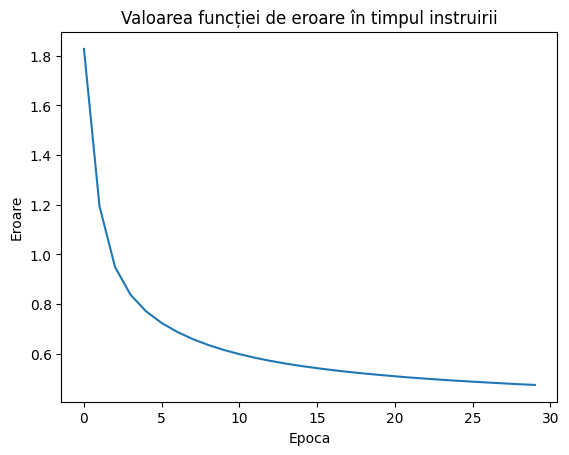

In [ ]:
plt.plot(losses)
plt.xlabel('Epoca')
plt.ylabel('Eroare')
plt.title(f'Valoarea funcției de eroare în timpul instruirii')
plt.show()

12. Afisarea evolutiei acuratetii pe setul de testare:

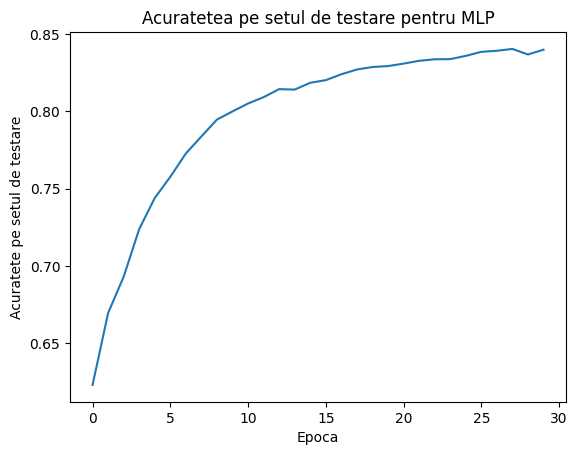

In [ ]:
plt.plot(accuracies)
plt.xlabel('Epoca')
plt.ylabel('Acuratete pe setul de testare')
plt.title(f'Acuratetea pe setul de testare pentru MLP')
plt.show()

13. Matricea de confuzie:

In [ ]:
def print_confusion_matrix(model: torch.nn.Module, loader: DataLoader, device: torch.device, num_classes: int = 10, normalize: Optional[Union[str, None]] = None) -> np.ndarray:
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Create confusion matrix
    cm:np.ndarray = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes), normalize=normalize)

    # Display confusion matrix
    print("Confusion Matrix:")
    print(cm)
    return cm

cm:np.ndarray = print_confusion_matrix(model, test_loader, device, num_classes=10)

Confusion Matrix:
[[796  10  13  51   2   3 108   0  17   0]
 [  0 953  16  23   1   0   7   0   0   0]
 [ 10   2 768   8 113   0  84   0  15   0]
 [ 36  23  17 866  27   0  29   0   2   0]
 [  0   2  95  35 770   0  95   0   3   0]
 [  1   1   0   1   0 887   0  57  10  43]
 [147   7 108  32  75   1 609   0  21   0]
 [  0   0   0   0   0  40   0 870   0  90]
 [  1   0  10   6   5   5  18   6 947   2]
 [  0   0   0   0   0  15   0  52   1 932]]
